In [1]:
with open('README.convote', 'r') as file:
    readme_contents = file.read()
    print(readme_contents)

Congress votes network, part of the Koblenz Network Collection

This directory contains the TSV and related files of the convote network: In this network, nodes are politicians speaking in the United States Congress, and a directed edge denotes that a speaker mentions another speaker.  The weight of an edge (positive or negative) denotes whether the mention is in support of or opposition to the mentioned politician.  Multiple parallel edges are possible.  Loops are allowed, i.e., speakers may mention themselves. 


More information about the network is provided here: 
http://konect.cc/networks/convote

Files: 
    meta.convote -- Metadata about the network 
    out.convote -- The adjacency matrix of the network in whitespace-separated values format, with one edge per line
      The meaning of the columns in out.convote are: 
        First column: ID of from node 
        Second column: ID of to node
        Third column (if present): weight or multiplicity of edge
        Fourth column

In [2]:
with open('meta.convote', 'r') as file:
    readme_contents = file.read()
    print(readme_contents)

name:  Congress votes
code:  CO
url:  http://www.cs.cornell.edu/home/llee/data/convote.html
category:  Interaction
cite:  konect:convote
long-description:  In this network, nodes are politicians speaking in the United States Congress, and a directed edge denotes that a speaker mentions another speaker.  The weight of an edge (positive or negative) denotes whether the mention is in support of or opposition to the mentioned politician.  Multiple parallel edges are possible.  Loops are allowed, i.e., speakers may mention themselves. 
entity-names:  politician
relationship-names:  mention
extr:  convote
timeiso:  2005
tags:  #loop



In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

filepath = 'out.convote'

#timestamp not present
network_data = pd.read_csv(filepath, sep=' ', header=None, skiprows=1, names=['from_node', 'to_node', 'weight'])

print(network_data.head())


   from_node  to_node  weight
0          1        2       1
1          1        2       1
2          1        2       1
3          1        3      -1
4          1        4      -1


In [5]:
network_data.shape

(764, 3)

In [6]:
network_data.isna().sum()

from_node    0
to_node      0
weight       0
dtype: int64

In [7]:
network_data.dtypes

from_node    int64
to_node      int64
weight       int64
dtype: object

In [8]:
# Create a directed graph
G = nx.from_pandas_edgelist(network_data, 'from_node', 'to_node', ['weight'], create_using=nx.DiGraph())

# If your file includes 'weight' or 'timestamp', they will be included as edge attributes

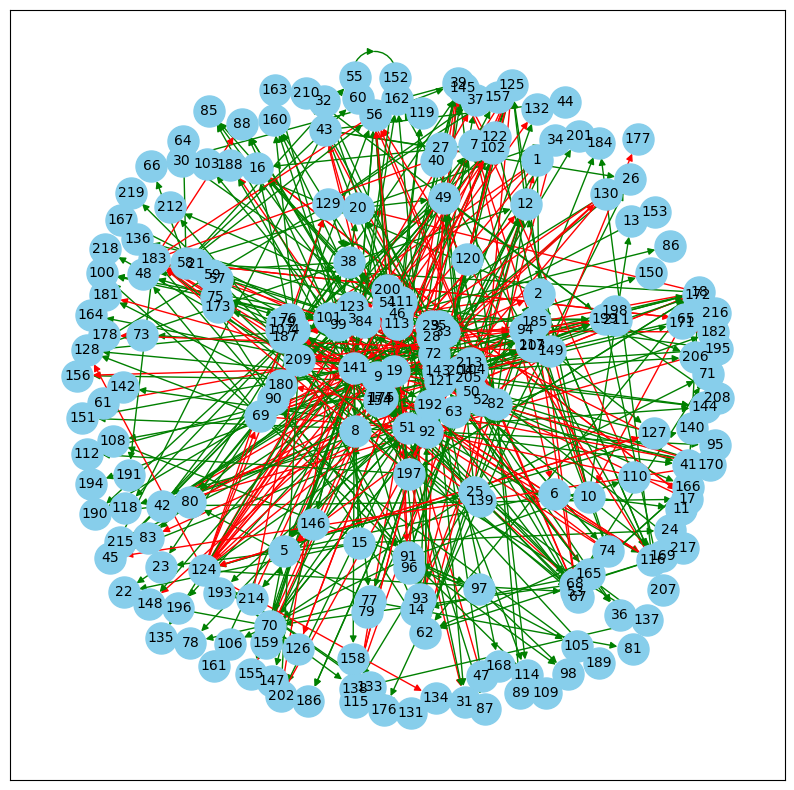

In [7]:
edge_colors = ['green' if data['weight'] >= 0 else 'red' for u, v, data in G.edges(data=True)]
plt.figure(figsize=(10,10))
nx.draw_networkx(G, with_labels=True, node_color='skyblue', edge_color=edge_colors, font_size=10, node_size=500)
plt.show()

## Question 1
Community Detection: Analyze the dataset to identify clusters or communities within Congress. This could reveal which politicians tend to group together based on mutual support or opposition, possibly reflecting political affiliations or alignments on specific issues.

In [9]:
!pip install python-louvain

     ---------------------------------------- 0.0/204.6 kB ? eta -:--:--
     -- ------------------------------------- 10.2/204.6 kB ? eta -:--:--
     -- ------------------------------------- 10.2/204.6 kB ? eta -:--:--
     ------- ----------------------------- 41.0/204.6 kB 326.8 kB/s eta 0:00:01
     --------------------- -------------- 122.9/204.6 kB 798.9 kB/s eta 0:00:01
     -------------------------------------- 204.6/204.6 kB 1.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9403 sha256=3c63

ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'C:\\Python312\\Scripts\\community'
Consider using the `--user` option or check the permissions.



In [11]:
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def same_structure(G):
    positive_edges = [(u, v, abs(d['weight'])) for u, v, d in G.edges(data=True) if d['weight'] > 0]
    negative_edges = [(u, v, abs(d['weight'])) for u, v, d in G.edges(data=True) if d['weight'] < 0]

    G_positive = nx.Graph()
    G_negative = nx.Graph()

    G_positive.add_weighted_edges_from(positive_edges)
    G_negative.add_weighted_edges_from(negative_edges)

    # Ensure all nodes are present in both graphs
    all_nodes = set(G.nodes())
    G_positive.add_nodes_from(all_nodes - set(G_positive.nodes()))
    G_negative.add_nodes_from(all_nodes - set(G_negative.nodes()))

    # Use a layout based on the complete graph
    pos = nx.spring_layout(G)  # This positions all nodes

    # Community detection for positive subgraph
    pos_partition = community_louvain.best_partition(G_positive, weight='weight')
    pos_cmap = cm.get_cmap('Greens', max(pos_partition.values()) + 1)
    pos_colors = [pos_cmap(pos_partition[node]) if node in pos_partition else (1, 1, 1) for node in G.nodes()]

    # Community detection for negative subgraph
    neg_partition = community_louvain.best_partition(G_negative, weight='weight')
    neg_cmap = cm.get_cmap('Reds', max(neg_partition.values()) + 1)
    neg_colors = [neg_cmap(neg_partition[node]) if node in neg_partition else (1, 1, 1) for node in G.nodes()]

    # Plotting
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    nx.draw_networkx(G, pos, node_color=pos_colors, with_labels=True, font_size=10, node_size=500, edge_color='darkgreen')
    plt.title('Positive Relationships')

    plt.subplot(1, 2, 2)
    nx.draw_networkx(G, pos, node_color=neg_colors, with_labels=True, font_size=10, node_size=500, edge_color='darkred')
    plt.title('Negative Relationships')

    plt.show()

In [12]:
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def grouped_structure(G):

    # Create subgraphs for positive and negative weights
    positive_edges = [(u, v, abs(d['weight'])) for u, v, d in G.edges(data=True) if d['weight'] > 0]
    negative_edges = [(u, v, abs(d['weight'])) for u, v, d in G.edges(data=True) if d['weight'] < 0]

    G_positive = nx.Graph()
    G_negative = nx.Graph()

    G_positive.add_weighted_edges_from(positive_edges)
    G_negative.add_weighted_edges_from(negative_edges)

    # Convert to undirected graphs
    G_pos_undirected = G_positive.to_undirected()
    G_neg_undirected = G_negative.to_undirected()

    # Community detection on positive subgraph
    pos_partition = community_louvain.best_partition(G_pos_undirected, weight='weight')
    pos_cmap = cm.get_cmap('Greens', max(pos_partition.values()) + 1)
    pos_colors = [pos_cmap(pos_partition[node]) for node in G_pos_undirected.nodes()]

    # Community detection on negative subgraph
    neg_partition = community_louvain.best_partition(G_neg_undirected, weight='weight')
    neg_cmap = cm.get_cmap('Reds', max(neg_partition.values()) + 1)
    neg_colors = [neg_cmap(neg_partition[node]) for node in G_neg_undirected.nodes()]

    # Plotting
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    nx.draw_networkx(G_pos_undirected, node_color=pos_colors, with_labels=True, font_size=10, node_size=500, edge_color='darkgreen')
    plt.title('Positive Relationships')

    plt.subplot(1, 2, 2)
    nx.draw_networkx(G_neg_undirected, node_color=neg_colors, with_labels=True, font_size=10, node_size=500, edge_color='darkred')
    plt.title('Negative Relationships')

    plt.show()


C:\Users\tomin\AppData\Local\Temp\ipykernel_42544\1098297497.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pos_cmap = cm.get_cmap('Greens', max(pos_partition.values()) + 1)
C:\Users\tomin\AppData\Local\Temp\ipykernel_42544\1098297497.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  neg_cmap = cm.get_cmap('Reds', max(neg_partition.values()) + 1)


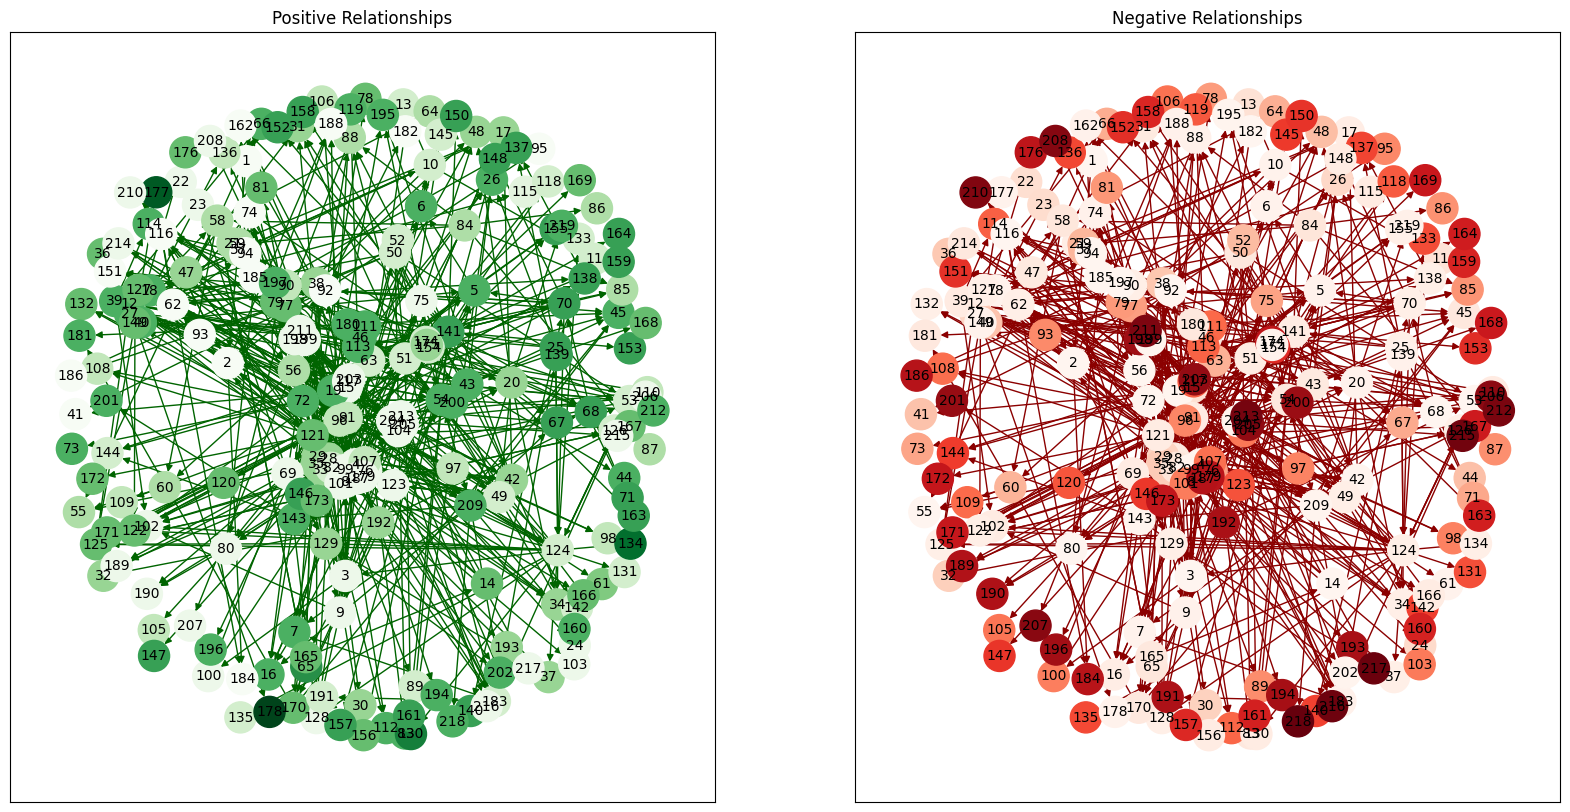

C:\Users\tomin\AppData\Local\Temp\ipykernel_42544\1119714660.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pos_cmap = cm.get_cmap('Greens', max(pos_partition.values()) + 1)
C:\Users\tomin\AppData\Local\Temp\ipykernel_42544\1119714660.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  neg_cmap = cm.get_cmap('Reds', max(neg_partition.values()) + 1)


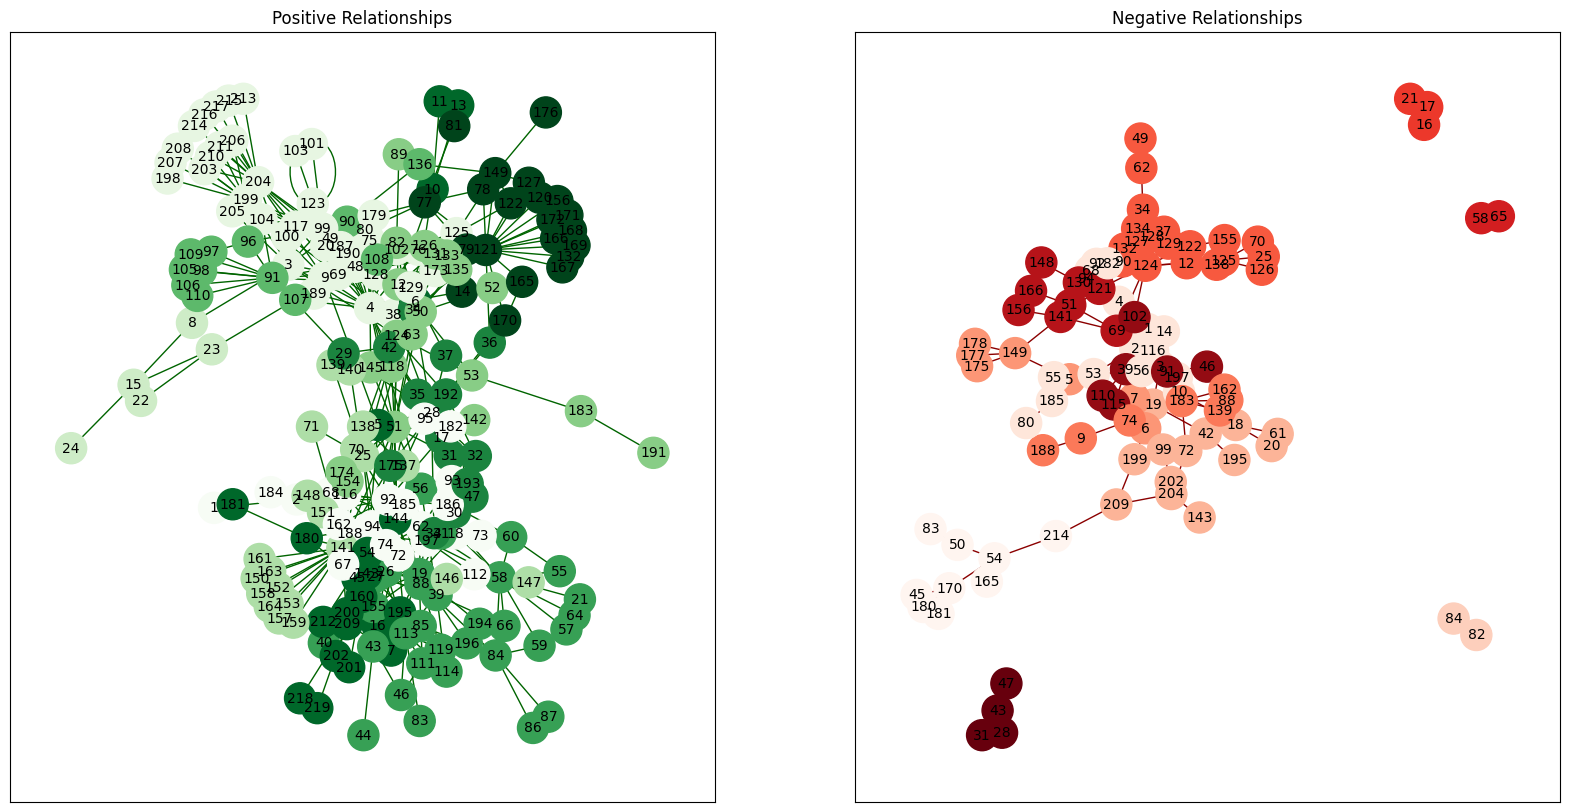

In [13]:
same_structure(G)
grouped_structure(G)

### Positive Relationships:
The visualization of positive relationships shows a highly interconnected network with several dense clusters. These clusters could represent groups of politicians who frequently support one another or collaborate on similar issues.

The large central cluster suggests a core group that might dominate discussions or legislative initiatives. Smaller clusters or isolated nodes might represent specialized interests or less influential members.
### Negative Relationships:
The negative relationship visualization appears less dense and more fragmented. This suggests that opposition or conflict within the network is not as tightly grouped and may involve more sporadic or less consistent interactions.

The spread of smaller clusters and isolated nodes indicates that opposition might not be as centrally organized and could be more about individual disagreements rather than large, organized blocks of opposition.

### Community Structure: 
Positive relationships tend to form more robust and cohesive communities, indicating stronger and potentially more permanent alliances. Negative relationships, on the other hand, create smaller and more dispersed groups, which could be temporary alignments formed in response to specific issues.
### Political Implications: 
The structure of positive relationships might reflect stable political coalitions or party lines, whereas the structure of negative relationships might reflect transient opposition that arises in response to particular legislative matters. This can inform strategies for consensus-building or conflict resolution.
### Role of Isolated Nodes: 
Nodes that appear isolated or in smaller clusters in the negative network but not in the positive might represent politicians who are generally agreeable with the majority but take specific independent stands on certain issues, causing them to occasionally face opposition.

## Question 2
Centrality Analysis: Determine the most influential members of Congress by measuring centrality metrics such as betweenness, closeness, and eigenvector centrality. This could help identify key players whose positions or mentions carry more weight in legislative discussions.

C:\Users\roder\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
C:\Users\roder\AppData\Local\Temp\ipykernel_15232\1362046250.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(betweenness_values), vmax=max(betweenness_values))),


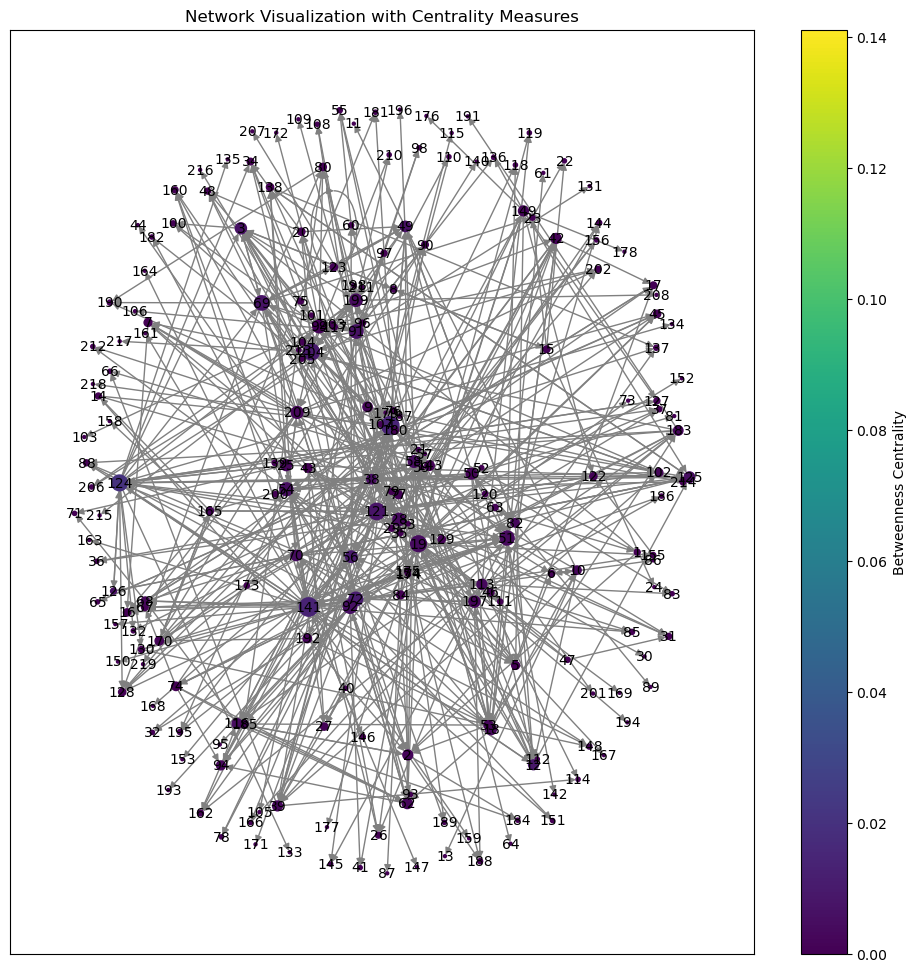

In [12]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

degree_sizes = [v * 1000 for v in degree_centrality.values()]  # Scale by 1000 for visibility, adjust as needed

# Node color proportional to betweenness centrality
# Create a color map from centrality values
betweenness_values = list(betweenness_centrality.values())
closeness_values = list(closeness_centrality.values())

# Create a colormap for betweenness centrality
betweenness_colors = plt.cm.viridis(betweenness_values)

plt.figure(figsize=(12, 12))
# Draw the network
nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=True,
                 node_color=betweenness_colors, node_size=degree_sizes,
                 edge_color='grey', font_size=10, cmap=plt.cm.viridis)

plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(betweenness_values), vmax=max(betweenness_values))),
             label='Betweenness Centrality')

plt.title('Network Visualization with Centrality Measures')
plt.show()

## Node Size and Degree Centrality
Larger nodes, which represent higher degree centrality, are those that have more connections. This suggests that these nodes are actively involved in multiple discussions or topics, indicating their active participation in the network. Politically, these individuals may frequently voice opinions, propose initiatives, or be highly active in debates, making them central figures.

## Network Density and Structure
The overall density of the network, with numerous overlapping edges and closely packed nodes, indicates a high level of interconnectedness among the nodes. This can suggest a legislative body where many members interact with each other, potentially indicating healthy debate and collaboration or, conversely, significant contention and opposition.

## Clusters and Isolated Nodes
While the network seems densely connected in the center, there are also nodes on the periphery with fewer connections and lower centrality. These nodes might represent less influential or more isolated political figures, possibly newer members, those with more specialized roles, or those from minority groups within the political landscape.

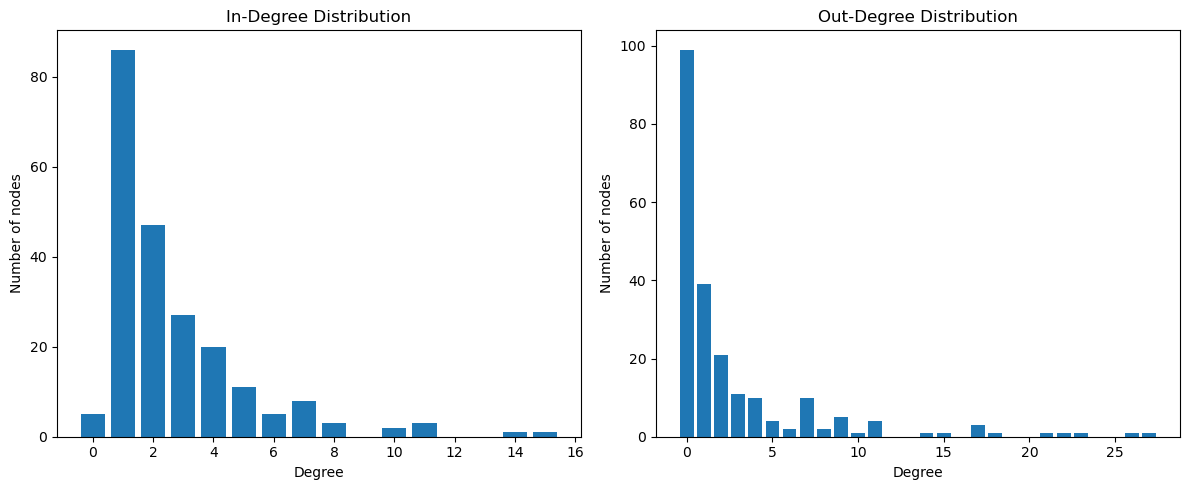

In [13]:
import collections

# Compute in-degrees and out-degrees
in_degrees = dict(G.in_degree())  # Returns a dictionary with node:in-degree
out_degrees = dict(G.out_degree())  # Returns a dictionary with node:out-degree

# Create frequency distributions
in_degree_values = sorted(set(in_degrees.values()))
in_degree_hist = [list(in_degrees.values()).count(x) for x in in_degree_values]

out_degree_values = sorted(set(out_degrees.values()))
out_degree_hist = [list(out_degrees.values()).count(x) for x in out_degree_values]

# Plotting the distributions
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.bar(in_degree_values, in_degree_hist)
plt.title('In-Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')

plt.subplot(122)
plt.bar(out_degree_values, out_degree_hist)
plt.title('Out-Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')

plt.tight_layout()
plt.show()

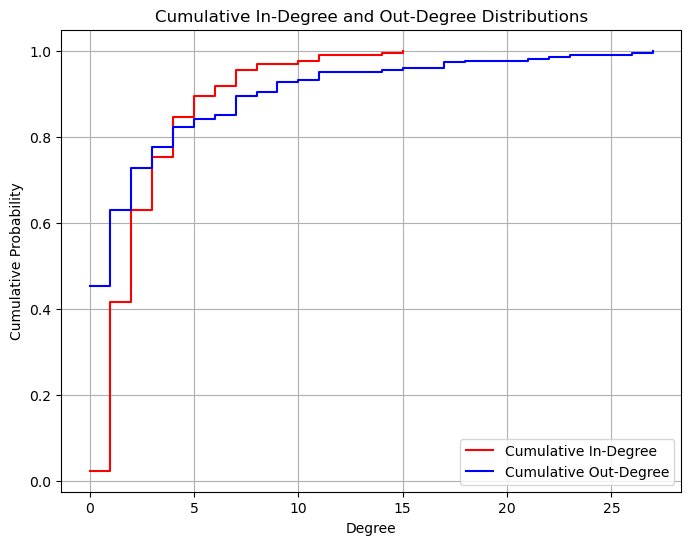

In [15]:
import numpy as np

# Calculate cumulative distributions
def cumulative_distribution(degrees):
    counts = collections.Counter(degrees)
    sorted_degrees = sorted(counts.items())
    cumsum = np.cumsum([count for _, count in sorted_degrees])
    total = sum(counts.values())
    return [degree for degree, _ in sorted_degrees], cumsum / total

# Compute cumulative degree distributions
in_degree_values, in_degree_cum_prob = cumulative_distribution(list(in_degrees.values()))
out_degree_values, out_degree_cum_prob = cumulative_distribution(list(out_degrees.values()))

# Plotting cumulative distributions on the same graph
plt.figure(figsize=(8, 6))
plt.step(in_degree_values, in_degree_cum_prob, where="post", label='Cumulative In-Degree', color='red')
plt.step(out_degree_values, out_degree_cum_prob, where="post", label='Cumulative Out-Degree', color='blue')
plt.title('Cumulative In-Degree and Out-Degree Distributions')
plt.xlabel('Degree')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()


### Question 3: How does self-mentioning affect the network ?
 - How do politicians talk about themselves ? Do they have a tendency of talking good about themselves ?
 - Does self-mentioning correlate with the centrality of a politician within the network ?

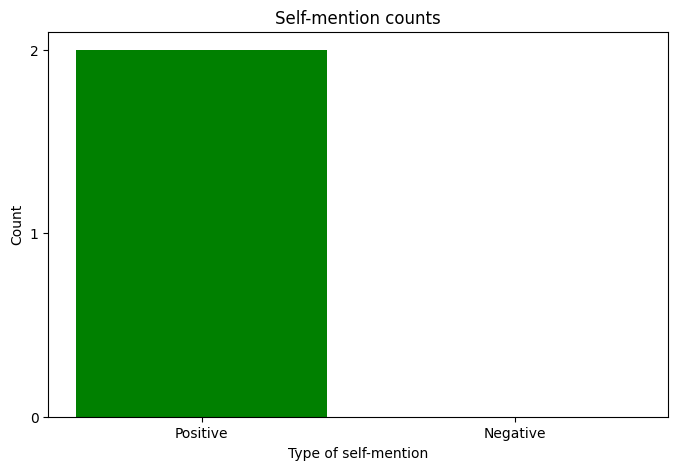

In [35]:
# How do politicians talk about themselves ? Do they have a tendency of talking good about themselves ?

import networkx as nx
self_mentions = {node: 0 for node in G.nodes()}
total_self_mentions = 0
positive_self_mentions = 0
negative_self_mentions = 0
self_mentioning_politicians = []

for u, v, data in G.edges(data=True):
    w = data['weight']
    if u == v:
        total_self_mentions += 1
        self_mentioning_politicians.append((u, w))
        if w:
            self_mentions[u] += 1
            positive_self_mentions += 1
        else:
            self_mentions[u] += 1
            negative_self_mentions += 1

categories = ['Positive', 'Negative']
values = [positive_self_mentions, negative_self_mentions]

plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['green', 'red'])
plt.title('Self-mention counts')
plt.xlabel('Type of self-mention')
plt.ylabel('Count')
plt.yticks(range(0, max(values) + 1, 1))
plt.show()

##### Conclusion:
There is not enough self-mentioning politicians to proceed with this analysis and extract useful insight and draw conclusions.

...

